In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [3]:
n_321g=gto.basis.load(bse.get_basis("3-21G",fmt="nwchem",elements=["N"]),"N")
c_321g=gto.basis.load(bse.get_basis("3-21G",fmt="nwchem",elements=["C"]),"C")
n_321g,"*******************",c_321g

([[0,
   [242.766, 0.05986570051],
   [36.4851, 0.352955003],
   [7.81449, 0.706513006]],
  [0, [5.42522, -0.4133000774], [1.14915, 1.224417267]],
  [0, [0.283205, 1.0]],
  [1, [5.42522, 0.2379720162], [1.14915, 0.8589530586]],
  [1, [0.283205, 1.0]]],
 '*******************',
 [[0,
   [172.256, 0.06176690738],
   [25.9109, 0.3587940429],
   [5.53335, 0.7007130837]],
  [0, [3.66498, -0.3958951621], [0.770545, 1.215834356]],
  [0, [0.195857, 1.0]],
  [1, [3.66498, 0.2364599466], [0.770545, 0.8606188057]],
  [1, [0.195857, 1.0]]])

Per gli orbitali "s" vale la formula $<g_ig_j>=c_i^2+c_j^2+c_ic_j*(2\sqrt{a_ia_j}/(a_i+a_j))^{3/2}$

In [4]:
0.4133000774**2+ 1.224417267**2 -2*0.4133000774*1.224417267*(2*(5.42522*1.14915)**.5/(5.42522+1.14915))**(3/2)

1.0000000003075527

In [5]:
1.215834356**2+0.3958951621**2 -2*1.215834356*0.3958951621*(2*(3.66498*0.770545)**.5/(3.66498+0.770545))**(3/2)

1.000000000624618

Per gli orbitali "p" vale la formula $<g_ig_j>=c_i^2+c_j^2+c_ic_j*(2\sqrt{a_ia_j}/(a_i+a_j))^{5/2}$

In [6]:
0.2364599466**2+0.8606188057**2 +2*0.2364599466*0.8606188057*(2*(3.66498*0.770545)**.5/(3.66498+0.770545))**(5/2)

0.999999999942027

In [7]:
c_321=gto.basis.load(bse.get_basis("3-21g",fmt="nwchem",elements=["C"]),"C")
o_321=gto.basis.load(bse.get_basis("3-21g",fmt="nwchem",elements=["O"]),"O")
f_321=gto.basis.load(bse.get_basis("3-21g",fmt="nwchem",elements=["F"]),"F")

In [8]:
f_321

[[0,
  [413.801, 0.05854830293],
  [62.2446, 0.3493080175],
  [13.434, 0.7096320355]],
 [0, [9.77759, -0.4073262777], [2.08617, 1.223137831]],
 [0, [0.482383, 1.0]],
 [1, [9.77759, 0.2466800032], [2.08617, 0.852321011]],
 [1, [0.482383, 1.0]]]

In [43]:
def g321(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("3-21g",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=g321(ref)
        rbm=g321(ref-1)
        rbp=g321(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  
            for j in range(1,len(fb[i])):
                a=(rbp[i][j][0]-rbm[i][j][0])/2
                b=(rbp[i][j][0]+rbm[i][j][0]-2*rb[i][j][0])
                fb[i][j][0]+=a*(z-ref)+b*(z-ref)**2
                a=(rbp[i][j][1]-rbm[i][j][1])/2
                b=(rbp[i][j][1]+rbm[i][j][1]-2*rb[i][j][1])
                fb[i][j][1]+=a*(z-ref)+b*(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [44]:
g321(6,ref=6),g321(6.5,ref=6),g321(7,ref=6)

([[0,
   [172.256, 0.06176690738],
   [25.9109, 0.3587940429],
   [5.53335, 0.7007130837]],
  [0, [3.66498, -0.3958951621], [0.770545, 1.215834356]],
  [0, [0.195857, 1.0]],
  [1, [3.66498, 0.2364599466], [0.770545, 0.8606188057]],
  [1, [0.195857, 1.0]]],
 [[0,
   [207.511, 0.060816303945],
   [31.198, 0.35587452295],
   [6.673920000000001, 0.70361304485]],
  [0, [4.545100000000001, -0.40459761974999997], [0.9598475, 1.2201258115]],
  [0, [0.239531, 1.0]],
  [1, [4.545100000000001, 0.2372159814], [0.9598475, 0.8597859321500001]],
  [1, [0.239531, 1.0]]],
 [[0,
   [242.766, 0.05986570051],
   [36.4851, 0.352955003],
   [7.81449, 0.706513006]],
  [0, [5.42522, -0.4133000774], [1.14915, 1.224417267]],
  [0, [0.283205, 1.0]],
  [1, [5.42522, 0.2379720162], [1.14915, 0.8589530586]],
  [1, [0.283205, 1.0]]])

In [45]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

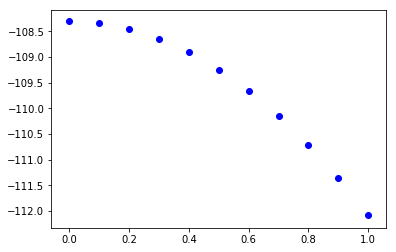

In [46]:
for i in np.linspace(0,1,11):
    plt.scatter(i,E(i),color="blue")

In [47]:
eT_R=E(-1,zbs=False)

In [48]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("3-21g"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("3-21g"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.087946327174
converged SCF energy = -108.300940981306


In [49]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [50]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.30094098130604,
  -108.30094098130553,
  -112.13054159958025,
  -112.13054159959061,
  -112.01279939214008,
  -112.01279939209863,
  -112.15540439871678],
 -112.08794632717384,
 [5.084821452783217e-13,
  -3.829600618274719,
  -1.0362081563168126e-11,
  0.11774220745053297,
  4.1448326252672496e-11,
  -0.14260500661814976])

In [52]:
dl=.1
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.30094098130604,
  -108.30094098130712,
  -112.13048455757138,
  -112.13048455754769,
  -112.0198726005909],
 -112.08794632717384,
 [-1.0835776720341528e-12,
  -3.8295435762642596,
  2.368475785867e-11,
  0.11061195695679277])

In [53]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,eT_R,e_co,inc

([-108.30094098130604,
  -108.30094098130526,
  -110.22324647198678,
  -110.22324647219757,
  -110.24579661902592,
  -110.2457966097415,
  -110.2481796563904],
 -110.24815024580921,
 -112.08794632717384,
 [7.771561172376096e-13,
  -1.9223054906815302,
  -2.10794344942163e-10,
  -0.022550146828355835,
  9.284425080598641e-09,
  -0.0023830466489016535])

In [56]:
def E_cn(l):
    mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [57]:
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("3-21g"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()

converged SCF energy = -91.7315947659029


In [58]:
dl=.1
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn

(array([-108.30094098,  -90.14371677,  -91.7765573 ,  -91.73488619,
         -91.72561179,  -91.72293386,  -91.72391797]),
 -91.73159476590291,
 array([-1.65693462e+01,  1.58787799e+00, -4.49625366e-02, -3.29142410e-03,
         5.98297472e-03,  8.66090550e-03,  7.67679674e-03]))

In [22]:
#check if basis are orthonormal

In [24]:
def S(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    #e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return mf_l.get_ovlp()

In [54]:
for i in np.linspace(0,1,7):
    print(S(i).diagonal())  #automatic normalization

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(<matplotlib.image.AxesImage at 0x7f7e3cdeb278>,
 <matplotlib.image.AxesImage at 0x7f7e3cbaf2e8>)

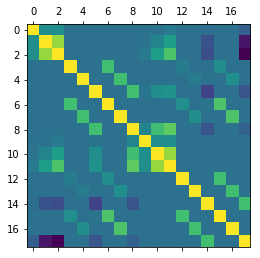

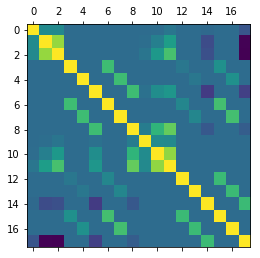

In [55]:
plt.matshow(S(0)),plt.matshow(S(.5))